In [1]:
!git clone https://github.com/alaybaa/ANAD-Arabic-News-Article-Dataset.git

Cloning into 'ANAD-Arabic-News-Article-Dataset'...
remote: Enumerating objects: 500265, done.
remote: Total 500265 (delta 0), reused 0 (delta 0), pack-reused 500265 (from 1)
Receiving objects: 100% (500265/500265), 497.60 MiB | 22.72 MiB/s, done.
Resolving deltas: 100% (173/173), done.
Updating files: 100% (500726/500726), done.


In [2]:
import os
print(os.listdir())

['ANAD-Arabic-News-Article-Dataset', '.virtual_documents']


In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load ANAD dataset
def load_anad_dataset(root_dir):
    data = []
    for platform in os.listdir(root_dir):
        platform_path = os.path.join(root_dir, platform)
        if os.path.isdir(platform_path):
            for topic in os.listdir(platform_path):
                topic_path = os.path.join(platform_path, topic)
                if os.path.isdir(topic_path):
                    for article_file in os.listdir(topic_path):
                        if article_file.endswith('.txt'):
                            article_path = os.path.join(topic_path, article_file)
                            with open(article_path, 'r', encoding='utf-8') as f:
                                content = f.read()
                            data.append({
                                'platform': platform,
                                'topic': topic,
                                'content': content
                            })
    return pd.DataFrame(data)

# Load data and limit to 50,000 samples
data = load_anad_dataset("./ANAD-Arabic-News-Article-Dataset")
data = data.iloc[:49000]  # Use first 50,00خ rows

print(data.head())  # Check if the data loaded correctly


     platform  topic                                            content
0  aawsat.com  Sport  رالي حائل: الدوسري يتجاوز العطل الفني ويتصدر ب...
1  aawsat.com  Sport  شاهد... شغب جماهيري يتسبب بإلغاء مباراة في كأس...
2  aawsat.com  Sport  الظفيري: التعادل ليس طموحنا لكنه كافٍ أمام ضمك...
3  aawsat.com  Sport  المدرجات الزرقاء ترفع «البطاقة الحمراء» في وجه...
4  aawsat.com  Sport  الاتحاد الآسيوي: تعديل مرتقب لمواعيد انطلاقة د...


In [4]:
# Custom dataset
class ChatbotDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        question = f"ماذا تعرف عن {row['topic']}؟"
        answer = row['content'][:512]  # Truncate to 512 characters

        inputs = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': inputs['input_ids'].flatten()
        }

In [5]:
# Training function
def train(model, train_loader, val_loader, optimizer, device, num_epochs):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs.logits, dim=-1)
            accuracy = (predictions == labels).float().mean().item()
            total_train_accuracy += accuracy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                predictions = torch.argmax(outputs.logits, dim=-1)
                accuracy = (predictions == labels).float().mean().item()
                total_val_accuracy += accuracy

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [6]:
# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at UBC-NLP/MARBERTv2 were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Epoch 1/2
Train Loss: 0.0169, Train Accuracy: 0.9920
Val Loss: 0.0149, Val Accuracy: 0.9922


Validation: 100%|██████████| 3130/3130 [22:35<00:00,  2.31it/s]


Epoch 2/2
Train Loss: 0.0052, Train Accuracy: 0.9983
Val Loss: 0.0000, Val Accuracy: 1.0000


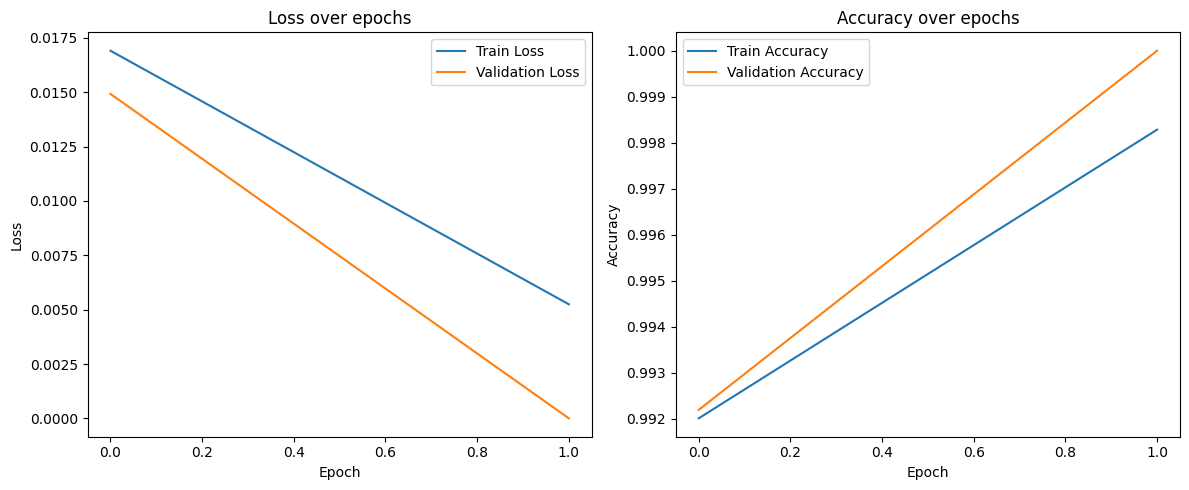

In [7]:
# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    dataset_path = "./ANAD-Arabic-News-Article-Dataset"
    df = load_anad_dataset(dataset_path)
    df['content'] = df['content'].apply(lambda x: ' '.join(x.split()[:100]))  # Use first 100 words

    # Split data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Initialize tokenizer and model
    model_name = "UBC-NLP/MARBERTv2"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)

    # Create datasets and dataloaders
    train_dataset = ChatbotDataset(train_df, tokenizer, max_length=128)
    val_dataset = ChatbotDataset(val_df, tokenizer, max_length=128)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model
    num_epochs = 2
    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, optimizer, device, num_epochs)

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save the model
    model.save_pretrained("./arabic_chatbot_model")
    tokenizer.save_pretrained("./arabic_chatbot_model")

In [8]:

    # Function to use the trained model
    def generate_response(question, max_length=150):
        input_ids = tokenizer.encode(question, return_tensors="pt").to(device)
        output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)
        return tokenizer.decode(output[0], skip_special_tokens=True)

    # Example usage
    question = "ماذا تعرف عن السيارات الكهربائية؟"
    response = generate_response(question)
    print(f"Question: {question}")
    print(f"Response: {response}")

Question: ماذا تعرف عن السيارات الكهربائية؟
Response: ماذا تعرف عن السيارات الكهربايية ؟👏 الله💜 😭😂😂🔲😜😂 🇸🇦🇸🇦🏃🏽👆👆📌😂❤❤💭💛🎯 👌😉 😂😂🤦🏻®💍 👌😍 😂😂انا ❗❗🙏 الله🌹 🔴عاجل 😙😙👦😂👊 متابعيك✔📩🎈🎬😥🇴🇲 💦💦📍ياهب ﺆ 😊❤📱 🙈🙈 👐👐 ❤💦 ﷺ💞📣 الحمدلله♥✊ل49 💙بطريقة🚩🙎 🇸🇦💚🌹🌹 😔💜 🎶🎶 💪💪🥇 😂👇 😔💔 🌹🌹 🌹❤🌹👇👇 🌸💙 نور💡 😴💛🌰 😂💕❌😑 😭💙💙💰 😂🚶🏻 ✅♦
